<a href="https://colab.research.google.com/github/glukonatic/III/blob/master/III_PRO_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №2 "Полносвязные сети, обучающая и тестовая выборки"
## студента Университета искусственного интеллекта
## Наговицына Антона Михайловича
### Поток PRO НС - апрель 2020 (основной тариф).
<img src="https://proza.ru/photos/glukonatic.jpg" alt="Фото Антон Наговицын" width="10%">

# Light

Создайте модель для распознавания рукописных цифр из набора MNIST (можно воспользоваться
ноутбуком 1-го занятия) и проведите ряд тестов:

1. Запустите сеть с различными размерами обучающей и проверочной выборок:
  *   Обучающая выборка 50.000 примеров
  *   Обучающая выборка 10.000 примеров
  *   Обучающая выборка 500 примеров

2. Создайте еще два варианта сети и сравните значения точности на проверочной выборке (на последней эпохе) и на тестовой выборке. Сделайте сравнительную таблицу.

3. Создайте сеть следующей архитектуры:
  *   Dense слоя
  *   Dropout слоя
  *   BatchNormalization слоя

Напишите свои выводы по результатам проведенных тестов.

In [0]:
#@title 0. Импорт библиотек и определение глобальных переменных и функций, необходимых для экспериментов для задания Light

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import numpy as np
import pylab as pl
import pandas as pd
from collections import defaultdict
from random import randint, choice
import math
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline


#@markdown Для построения модели можно указать размер обучающей выборки (defTrain). Для обучения - количество эпох defEpochs, параметром defVerbose можно установить отображение процесса обучения

defEpochs = 5 #@param {type:"number"}
defTrain = 50000 #@param {type:"number"}
defVerbose = "1" #@param [0, 1] {allow-input: false}
defNeyronsInput =  320
defHiddenLayers = 1
defNeyronsHidden = 128
defBatchSize = 128
defActivation = 'relu'

# Исходные данные датасета
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()

# Приведение данных датасета к необходимому виду
x_train = x_train_org.reshape(60000, 784)
x_test = x_test_org.reshape(10000, 784)
x_train = x_train.astype('float32')
x_train = x_train / 255
x_test = x_test.astype('float32')
x_test = x_test / 255
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)




class Model:
  '''
    Класс моделей
  '''
  
  def __init__(self, numOfNeyronsInput=defNeyronsInput, 
               numOfHiddenLayers=defHiddenLayers, 
               numOfNeyronsHidden=defNeyronsHidden, 
               activation=defActivation,
               listOfLayers=[]):
    '''
      Инициализация. Создается модель с заданными параметрами. Создаются элементы класса
    '''
    self.history = defaultdict()
    self.inputNeyrons = numOfNeyronsInput
    self.hiddenLayers = numOfHiddenLayers
    self.hiddenNeyrons = numOfNeyronsHidden
    self.activation = activation
    self.model = Sequential()
    self.model.add(Dense(self.inputNeyrons, input_dim=784, activation=self.activation))
    for i in range(self.hiddenLayers):    
      self.model.add(Dense(self.hiddenNeyrons, activation=self.activation))
    for layerType in listOfLayers:
      if layerType == 'BatchNormalization':
        self.model.add(BatchNormalization())
      if layerType == 'Dropout':
        self.model.add(Dropout(0.1))
      if layerType == 'Dense':
        self.model.add(Dense(30, activation='relu'))   
    self.model.add(Dense(10, activation="softmax"))

  def compileModel(self, optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']):
    '''
      Компиляция
    '''
    self.model.compile(optimizer, loss,  metrics)


  def fitModel(self, x_train=x_train, y_train=y_train, n_train=defTrain, 
               batchSize=defBatchSize, epochsNum=defEpochs, verboseBit=defVerbose):
    '''
      Обучение с указанными параметрами
    '''
    self.n_train = n_train
    self.batchSize = batchSize
    self.epochs = epochsNum
    self.history = self.model.fit(x_train[:self.n_train], 
                                  y_train[:self.n_train], 
                                  batch_size=self.batchSize, 
                                  epochs=self.epochs, 
                                  verbose=int(verboseBit), 
                                  validation_data=(x_train[self.n_train:], 
                                                   y_train[self.n_train:]))
  
  def scoreModel(self):
    '''
      Проверка на тестовых данных
    '''
    self.score = self.model.evaluate(x_test, y_test)




# Функция, рисующая графики на основании полученных данных в экспериментах
def runPlot(listOfModels,labels=[],mainLabel=['Графики']):
  '''
    Функция runPlot, отрисовывающая графики по полученным в экспериментах данным
    На вход принимает значения:
    paramDict - словарь полученных в результате экспериментов данных
    experimentName - определяет, какой эксперимент был проведён
    Функция ничего не возвращает
  '''
  # Инициализируем графики, их у нас всегда по два - для точности и для потерь
  f, ax = plt.subplots(2, 2, figsize = (25,10))
  f.suptitle(mainLabel)

  for model in listOfModels:
#    labels.append('in: ' + str(model.inputNeyrons) + \
#                  '  hidL: ' + str(model.hiddenLayers) + \
#                  '  hidN: ' + str(model.hiddenNeyrons) + \
#                  '  act: ' + model.activation + \
#                  '  n_train: ' + str(model.n_train))
    ax[0][0].plot(model.history.history['accuracy'])
    ax[0][1].plot(model.history.history['val_accuracy'])
    ax[1][0].plot(model.history.history['loss'])
    ax[1][1].plot(model.history.history['val_loss'])

  ax[0][0].set_title('Точность моделей на обучающей выборке')
  ax[0][0].set_ylabel('Точность')
  ax[0][0].set_xlabel('Эпохи')
  ax[0][0].grid(color='g', linestyle=':', linewidth=1)
  ax[0][0].legend(labels, loc='lower right')
  ax[1][0].set_title('Потери моделей на обучающей выборке')
  ax[1][0].set_ylabel('Потери')
  ax[1][0].set_xlabel('Эпохи')
  ax[1][0].grid(color='g', linestyle=':', linewidth=1)
  ax[1][0].legend(labels, loc='upper right')
  ax[0][1].set_title('Точность моделей на проверочной выборке')
  ax[0][1].set_ylabel('Точность')
  ax[0][1].set_xlabel('Эпохи')
  ax[0][1].grid(color='g', linestyle=':', linewidth=1)
  ax[0][1].legend(labels, loc='lower right')
  ax[1][1].set_title('Потери моделей на проверочной выборке')
  ax[1][1].set_ylabel('Потери')
  ax[1][1].set_xlabel('Эпохи')
  ax[1][1].grid(color='g', linestyle=':', linewidth=1)
  ax[1][1].legend(labels, loc='upper right')

Epoch 1/5
391/391 [==============================] - 3s 6ms/step - loss: 0.2877 - accuracy: 0.9172 - val_loss: 0.1330 - val_accuracy: 0.9624
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 0.0966 - val_accuracy: 0.9704
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 0.0700 - accuracy: 0.9784 - val_loss: 0.0852 - val_accuracy: 0.9742
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.0864 - val_accuracy: 0.9757
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 0.0359 - accuracy: 0.9884 - val_loss: 0.0818 - val_accuracy: 0.9754
Epoch 1/5
79/79 [==============================] - 2s 20ms/step - loss: 0.6052 - accuracy: 0.8365 - val_loss: 0.3106 - val_accuracy: 0.9109
Epoch 2/5
79/79 [==============================] - 1s 18ms/step - loss: 0.2201 - accuracy: 0.9381 - val_loss: 0.2529 - val_accuracy: 0.9234
Epoch 3/5
79/79

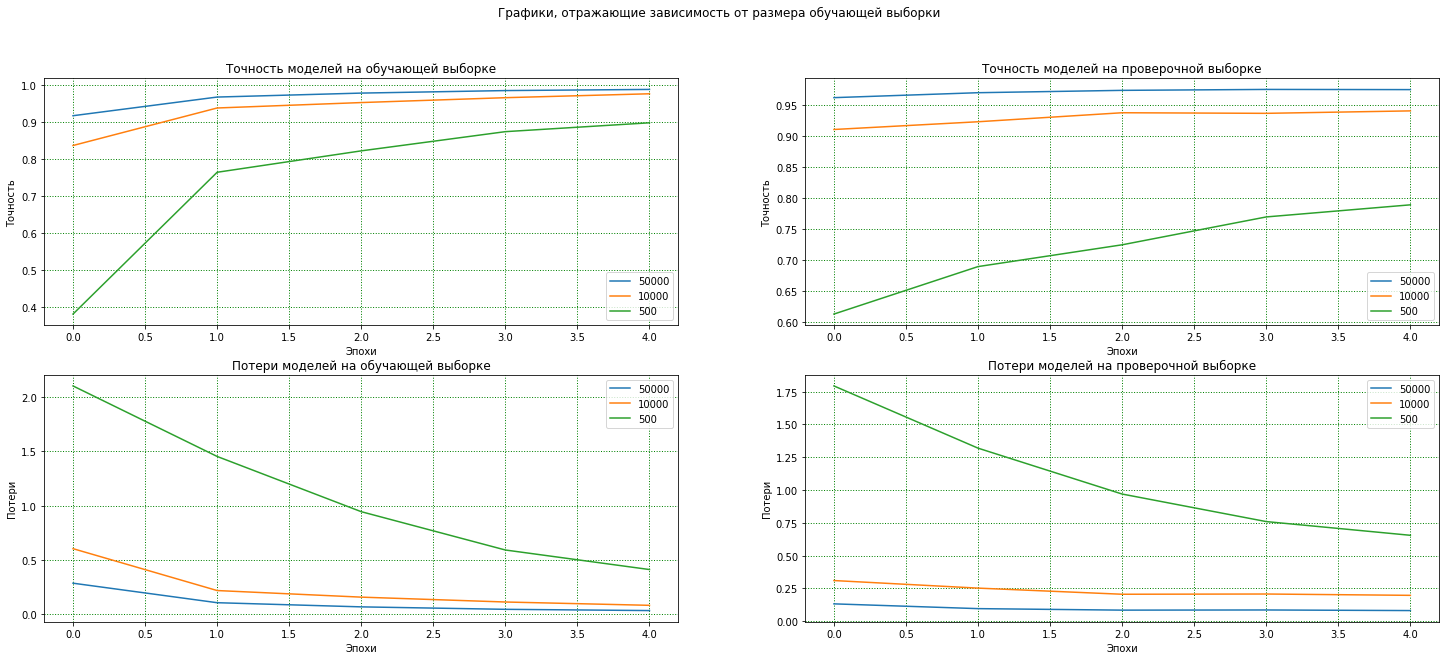

In [23]:
#@title 1. Запустите сеть с различными размерами обучающей и проверочной выборок (50000 / 10000 / 500 примеров в обучающей выборке)

#@markdown Для построения модели можно указать размер обучающей выборки (создадим три модели)

n_train1 = 50000 #@param {type:"number"}
n_train2 = 10000 #@param {type:"number"}
n_train3 = 500 #@param {type:"number"}

model_50k = Model()
model_10k = Model()
model_500 = Model()

model_50k.compileModel()
model_10k.compileModel()
model_500.compileModel()

model_50k.fitModel(n_train=n_train1)
model_10k.fitModel(n_train=n_train2)
model_500.fitModel(n_train=n_train3)

labels = [n_train1,n_train2,n_train3]
mainLabel = 'Графики, отражающие зависимость от размера обучающей выборки'
runPlot([model_50k,model_10k,model_500],labels,mainLabel)

In [0]:
#@title 2. Создайте еще два варианта сети и сравните значения точности на проверочной выборке (на последней эпохе) и на тестовой выборке. Сделайте сравнительную таблицу.

#@markdown Инициализация начала эксперимента 2, а так же сброс эксперимента 2 при уже имеющихся опытах.

models = []
labels = []

In [0]:
#@markdown Для построения кастомных моделей можно указать разные параметры. Каждый запуск этой ячейки дает +1 модель. 

random_or_manual = "\u0418\u0437 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u044B\u0445 \u043D\u0438\u0436\u0435 \u043F\u0430\u0440\u0430\u043C\u0435\u0442\u0440\u043E\u0432"  #@param ['Случайно', 'Из указанных ниже параметров']
neyronsInput =   800#@param {type:"number"}
hiddenLayers = 0 #@param {type:"number"}
neyronsHidden =  8#@param {type:"number"}
activation = 'hard_sigmoid'  #@param ['relu', 'linear', 'tanh', 'elu', 'selu', 'sigmoid', 'hard_sigmoid', 'exponential']

if random_or_manual == "Случайно":
  neyronsInput = choice([128,256,512])
  neyronsHidden = choice([64,128,256])
  hiddenLayers = choice([1,2])
  activation = choice(['relu', 'linear', 'tanh'])
  
if hiddenLayers > 0: 
  labels.append('Вход,нейронов:'+str(neyronsInput)+' внутр.слой,нейронов:'+str(neyronsHidden)+' внутр.слоёв:'+str(hiddenLayers)+' ф.актив:'+activation)
elif hiddenLayers == 0: 
  labels.append('Вход,нейронов:'+str(neyronsInput)+' внутр.слоёв:'+str(hiddenLayers)+' ф.актив:'+activation)
models.append(Model(numOfNeyronsInput=neyronsInput,numOfHiddenLayers=hiddenLayers,
                numOfNeyronsHidden=neyronsHidden,activation=activation))

Epoch 1/5
391/391 [==============================] - 5s 12ms/step - loss: 0.2713 - accuracy: 0.9219 - val_loss: 0.1384 - val_accuracy: 0.9612
Epoch 2/5
391/391 [==============================] - 5s 12ms/step - loss: 0.1081 - accuracy: 0.9682 - val_loss: 0.0904 - val_accuracy: 0.9738
Epoch 3/5
391/391 [==============================] - 4s 11ms/step - loss: 0.0683 - accuracy: 0.9796 - val_loss: 0.0845 - val_accuracy: 0.9742
Epoch 4/5
391/391 [==============================] - 4s 11ms/step - loss: 0.0463 - accuracy: 0.9872 - val_loss: 0.0739 - val_accuracy: 0.9794
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0646 - accuracy: 0.9805
Epoch 1/5
391/391 [==============================] - 4s 11ms/step - loss: 0.3756 - accuracy: 0.8899 - val_loss: 0.3083 - val_accuracy: 0.9154
Epoch 2/5
391/391 [==============================] - 4s 11ms/step - loss: 0.3118 - accuracy: 0.9113 - val_loss: 0.2890 - val_accuracy: 0.9178
Epoch 3/5
391/391 [==============================

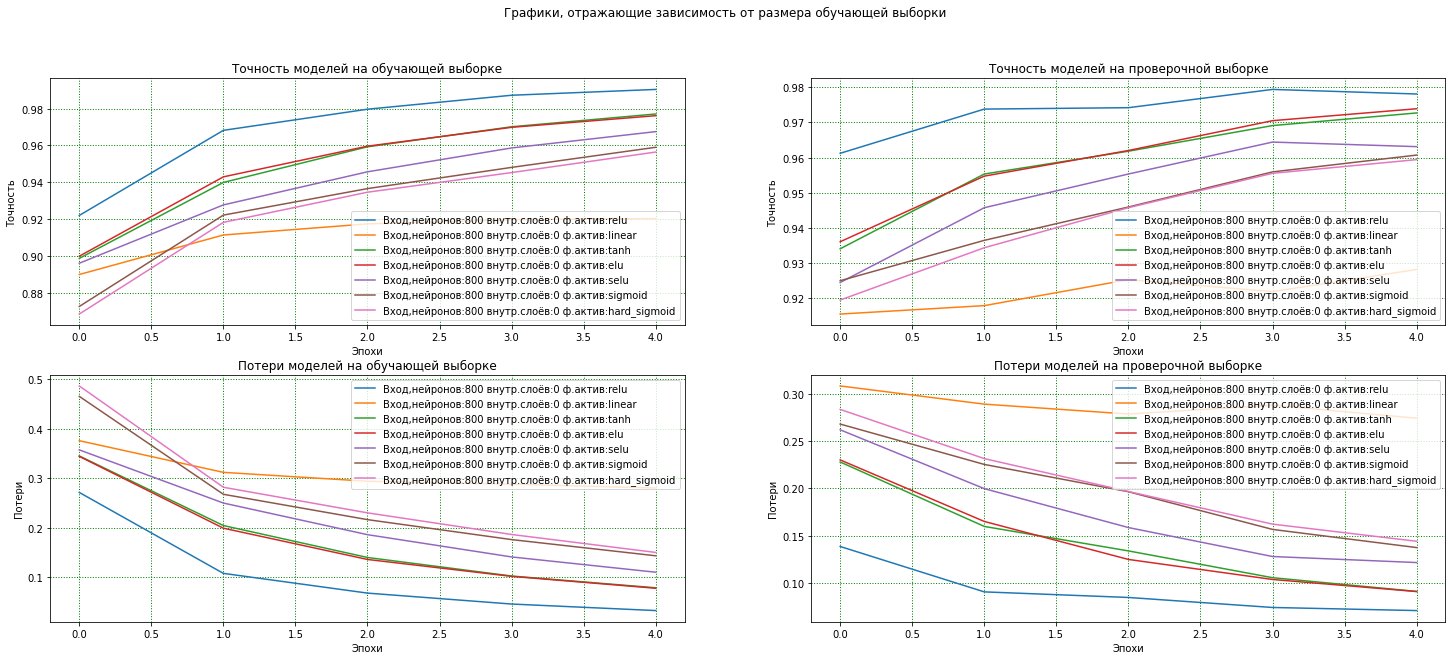

In [136]:
#@markdown Компиляция и обучение созданных моделей, построение графиков

for model in models:
  model.compileModel()
  model.fitModel()
  model.scoreModel()

mainLabel = 'Графики, отражающие зависимость от размера обучающей выборки'
runPlot(models,labels,mainLabel)

In [125]:
#@markdown Прогон тестовой порции сета данных, сведение итогов в таблицу

indexes = ['Нейронов на входе','Скрытых слоёв','Нейронов в скр.сл.','Функция активации',
           'Потери трен.набора','Потери тест.набора','Точность трен.набора','Точность тест.набора']

df = pd.DataFrame(index=indexes)

for i, model in enumerate(models):
  df[i+1] = [model.inputNeyrons,model.hiddenLayers,model.hiddenNeyrons,model.activation,
             model.history.history['val_loss'][-1],model.score[0],
             model.history.history['val_accuracy'][-1],model.score[1]]

print('Выведем сводную таблицу, полученную в результате проведения экспериментов. Строки - эксперименты')
df.T

Выведем сводную таблицу, полученную в результате проведения экспериментов. Строки - эксперименты


,Нейронов на входе,Скрытых слоёв,Нейронов в скр.сл.,Функция активации,Потери трен.набора,Потери тест.набора,Точность трен.набора,Точность тест.набора
1,800,0,8,relu,0.0758122,0.0696389,0.9771,0.9788
2,800,1,8,relu,0.0897254,0.0772062,0.9758,0.9754
3,800,1,100,relu,0.0902011,0.0845224,0.9735,0.9748
4,800,1,300,relu,0.0774998,0.0689815,0.9787,0.9806
5,800,1,800,relu,0.0699609,0.0752409,0.9812,0.9802
6,800,1,1400,relu,0.0882617,0.0798421,0.977,0.9791


Epoch 1/5
391/391 [==============================] - 3s 8ms/step - loss: 0.3048 - accuracy: 0.9097 - val_loss: 0.1410 - val_accuracy: 0.9593
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 0.1101 - accuracy: 0.9672 - val_loss: 0.0969 - val_accuracy: 0.9710
Epoch 3/5
391/391 [==============================] - 3s 8ms/step - loss: 0.0734 - accuracy: 0.9782 - val_loss: 0.0916 - val_accuracy: 0.9712
Epoch 4/5
391/391 [==============================] - 3s 8ms/step - loss: 0.0539 - accuracy: 0.9832 - val_loss: 0.0981 - val_accuracy: 0.9720
Epoch 5/5
391/391 [==============================] - 3s 8ms/step - loss: 0.0413 - accuracy: 0.9867 - val_loss: 0.0911 - val_accuracy: 0.9731
Epoch 1/5
391/391 [==============================] - 3s 7ms/step - loss: 0.2870 - accuracy: 0.9168 - val_loss: 0.1240 - val_accuracy: 0.9634
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 0.1053 - accuracy: 0.9683 - val_loss: 0.0989 - val_accuracy: 0.9706
Epoch 3/5
391

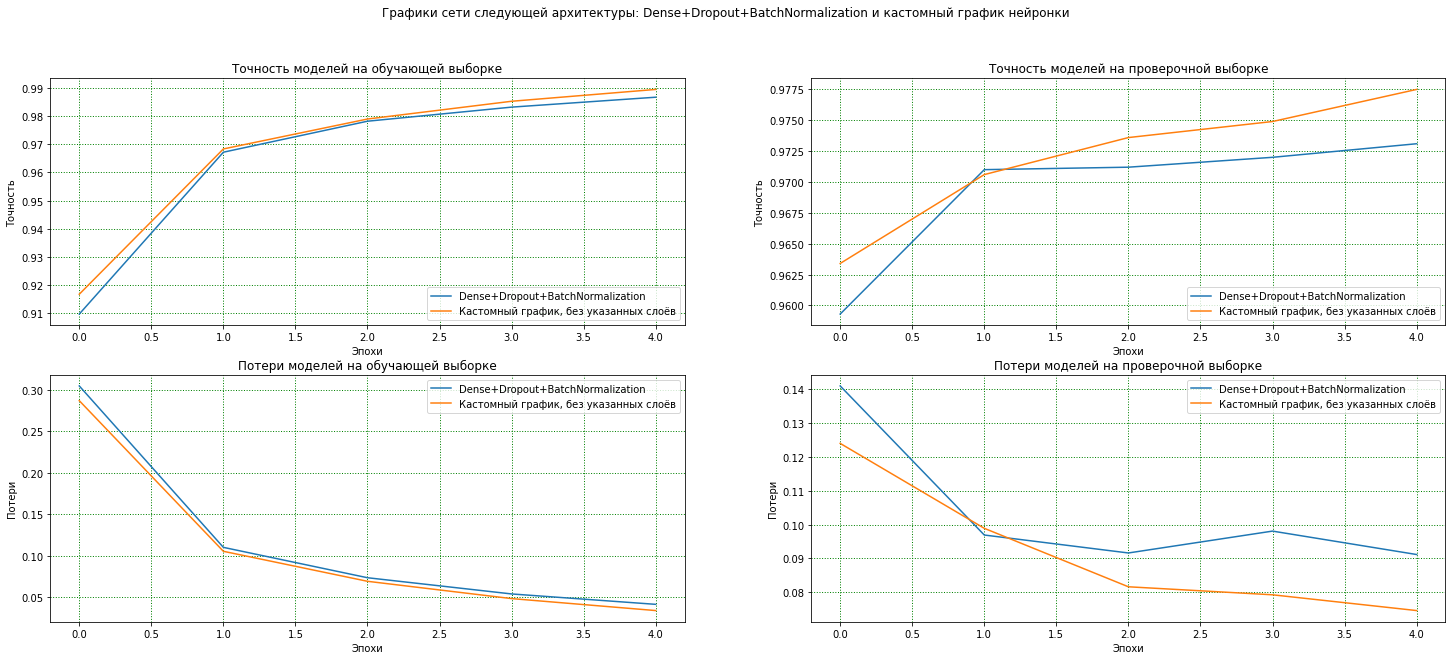

In [56]:
#@title Создайте сеть следующей архитектуры: Dense+Dropout+BatchNormalization

modelDDB = Model(listOfLayers=['BatchNormalization','Dropout','Dense'])
modelCustom = Model()

modelDDB.compileModel()
modelCustom.compileModel()

modelDDB.fitModel()
modelCustom.fitModel()

mainLabel = 'Графики сети следующей архитектуры: Dense+Dropout+BatchNormalization и кастомный график нейронки'
labels = ['Dense+Dropout+BatchNormalization','Кастомный график, без указанных слоёв']
runPlot([modelDDB,modelCustom],labels=labels,mainLabel=mainLabel)

Выводы:
1. Размер обучающей выборки напрямую влияет на качество обучения сети
2. Если сравнивать модели с одним внутренним слоем, то модель с 128 входными нейронами на первом слое и 8 нейронами на скрытом работает лучше, чем модель с 8 нейронами на первом слое и 128 на скрытом. Проводились несколько опытов. Но это только из-за того, что на 1 слое мало нейронов. Дальнейшие опыты показали, что чаще всего большее влияние имеет увеличение числа нейронов на скрытом слое. На первом слое можно сказать, должно быть какое-то оптимальное значение нейронов, достаточное для приятной функциональности нейронки.
3. Если сравнивать работу сетей без скрытого слоя, то можно сделать вывод, что при количестве нейронов равным 8 на первом слое модель уже даёт хорошую точность при прогоне тестового набора после обучения. Но так же надо отметить, что 800 нейронов на первом слое дают более высокую точность. При этом при повышении числа нейронов на входе более 800 нейронов, точность не увеличивается и колеблется около значения точности модели с 800 нейронами в первом слое.
4. При сравнении точности модели, не содержащей скрытого слоя, и содержащей на первом слое 800 нейронов, с работой моделей с разным количеством нейронов на скрытом слое, то можно сделать вывод, что скрытый слой вообще не нужен для решения этой задачи.
5. Введение в сеть слоёв Dropout и BatchNormalization не показывает своей необходимости и эффективность модели не повышают.

# Pro. Вариант 1

Повысьте точность модели по обнаружению мин до 90% на тестовой выборке. Можно использовать различные варианты слоев Dropout и BatchNormalization. Можно менять количество примеров в обучающей и проверочной выборках, но нельзя менять количество примеров в тестовой.

In [0]:
#@title Импорт библиотек и определение глобальных переменных и функций, необходимых для экспериментов для задания Pro. Вариант 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import tensorflow.keras.optimizers as opt
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import defaultdict
from random import randint, choice, seed
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline



# Инициализируем переменные для последующих экспериментов
defTestSize = 0.2 
defVerbose = "0" 
defDR = 10
defILR = 0.001
defDS = 100
defEpochs = 20




class NN:
    '''
      Класс моделей нейронки
    '''
  
  def __init__(self):
    self.history = defaultdict()   
    self.model = Sequential()
    self.layers = 0

  def createModel(self, 
                  optimizer='default',
                  listOfLayers=['BatchNormalization','Dropout','Dense'], 
                  firstLayerNeyrons=60, 
                  koeffDropOut=0.1,
                  initial_learning_rate=defILR,
                  decay_steps=defDS,
                  decay_rate=defDR):
    '''
      Конструктор. Создается модель с заданными параметрами. Создаются элементы класса
    '''

    ### def decayed_learning_rate(step):
    ###   return initial_learning_rate * decay_rate ^ (step / decay_steps)
    
    lr_schedule = opt.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
        )
    #print(lr_schedule)
    self.cSDG = opt.SGD(learning_rate=lr_schedule)
    self.cAdam = opt.Adam(learning_rate=lr_schedule)
    if optimizer=='default':
      optimizer=opt.Adam(0.001)
    elif optimizer=='customSDG':
      optimizer=self.cSDG
    elif optimizer=='customAdam':
      optimizer=self.cAdam
    self.model.add(Dense(firstLayerNeyrons, activation='relu', input_shape=(60, )))
    for layerType in listOfLayers:
      if layerType == 'BatchNormalization':
        self.model.add(BatchNormalization())
      if layerType == 'Dropout':
        self.model.add(Dropout(koeffDropOut))
      if layerType == 'Dense':
        self.model.add(Dense(30, activation='relu'))
      self.layers += 1
    self.model.add(Dense(1, activation='sigmoid'))
    self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


  def fitModel(self, x, y, v=0.2, batchSize=8, epochs=defEpochs, verboseBit=int(defVerbose)):
    '''
      Обучение модели с определёнными параметрами
    '''
    self.history = self.model.fit(x,y,batch_size=batchSize,epochs=epochs,validation_split=v,
                             verbose=verboseBit
                             #,callbacks=[earlyStopFit]
                             )
  
  def scoreModel(self, x, y):
    '''
      Прогон тестового сета
    '''
    self.score = self.model.evaluate(x, y)


# Функция, рисующая графики на основании полученных данных в экспериментах
def runPlot(listOfModels,labels=[],mainLabel='Графики'):
  '''
    Функция runPlot, отрисовывающая графики по полученным в экспериментах данным
    На вход принимает значения:
    listOfModels - список моделей класса NN
    labels - подписи к графикам (легенда)
    mainLabel - главная подпись к графикам
    Функция ничего не возвращает
  '''
  # Инициализируем графики, их у нас всегда по два - для точности и для потерь
  f, ax = plt.subplots(2, 2, figsize = (25,10))
  f.suptitle(mainLabel)

  for model in listOfModels:
    ax[0][0].plot(model.history.history['accuracy'])
    ax[0][1].plot(model.history.history['val_accuracy'])
    ax[1][0].plot(model.history.history['loss'])
    ax[1][1].plot(model.history.history['val_loss'])

  ax[0][0].set_title('Точность моделей на обучающей выборке')
  ax[0][1].set_title('Точность моделей на проверочной выборке')
  ax[1][0].set_title('Потери моделей на обучающей выборке')
  ax[1][1].set_title('Потери моделей на проверочной выборке')
  ax[0][0].grid(color='g', linestyle=':', linewidth=1)
  ax[1][0].grid(color='g', linestyle=':', linewidth=1)
  ax[0][1].grid(color='g', linestyle=':', linewidth=1)
  ax[1][1].grid(color='g', linestyle=':', linewidth=1)
  ax[0][0].legend(labels, loc='lower right')
  ax[0][1].legend(labels, loc='lower right')
  ax[1][0].legend(labels, loc='upper right')
  ax[1][1].legend(labels, loc='upper right')
  ax[0][0].set_ylabel('Точность')
  ax[0][0].set_xlabel('Эпохи')
  ax[0][1].set_ylabel('Точность')
  ax[0][1].set_xlabel('Эпохи')
  ax[1][0].set_ylabel('Потери')
  ax[1][0].set_xlabel('Эпохи')
  ax[1][1].set_ylabel('Потери')
  ax[1][1].set_xlabel('Эпохи')


goodModels = []

In [0]:
#@markdown Для построения модели можно указать часть сета, выделяемую под тесты defTestSize. Для обучения - параметром defVerbose можно установить отображение процесса обучения и defEpochs можно определить число эпох обучения

defTestSize = 0.2 #@param {type: "slider", min: 0.05, max: 0.5, step: 0.05}
defVerbose = "0"  #@param [0, 1] {allow-input: false}
defEpochs = 20 #@param {type:"number"}

In [0]:
#@title Загрузка сета мин
!rm sonar*
files.upload()
!ls # Выводим содержимое корневой папки

df = pd.read_csv("sonar.csv", header=None)
#df.head()    

dataArray = df.values
X = dataArray[:,0:60].astype(float)
Y = dataArray[:,60]
Y[Y=='R']='0'
Y[Y=='M']='1'
Y = Y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=defTestSize, shuffle=True)  

rm: cannot remove 'sonar*': No such file or directory


Saving sonar.csv to sonar.csv
sample_data  sonar.csv


2/2 [==============================] - 0s 3ms/step - loss: 0.5002 - accuracy: 0.7381


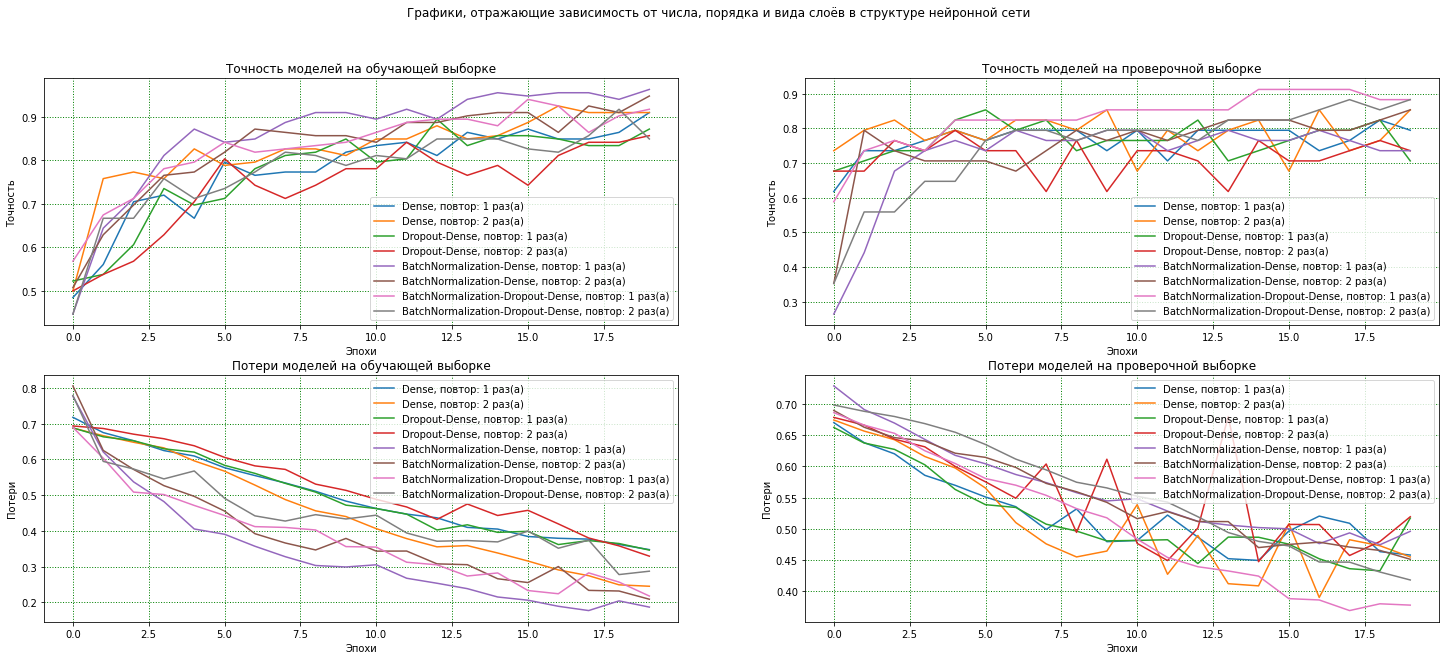

In [0]:
#@title Э1 [layers]. Ставим ряд экспериментов для выявления зависимости точности модели от числа и вида добавляемых слоёв в нейронку. Коэффициенты Dropout и validation_split берутся по умолчанию и равны, соответственно, 0.1 и 0.2.

testModels1 = []
numOfAddedLayers = 3
i = 0
labels = []
layersPack = [['Dense'],
              ['Dropout','Dense'],
              ['BatchNormalization','Dense'],
              ['BatchNormalization','Dropout','Dense']]

for layerPack in layersPack:
  for repeat in range(1,numOfAddedLayers):
    M = NN()
    M.createModel(listOfLayers=layerPack*repeat)
    M.fitModel(x_train, y_train)
    M.scoreModel(x_test, y_test)
    i += 1
    labels.append('-'.join(layerPack)+', повтор: '+str(repeat)+' раз(а)')
    testModels1.append(M)
    if M.score[1] >= 0.90:
      print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
      goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от числа, порядка и вида слоёв в структуре нейронной сети'
runPlot(testModels1,labels,mainLabel)

2/2 [==============================] - 0s 4ms/step - loss: 0.3587 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 4ms/step - loss: 0.5449 - accuracy: 0.6905


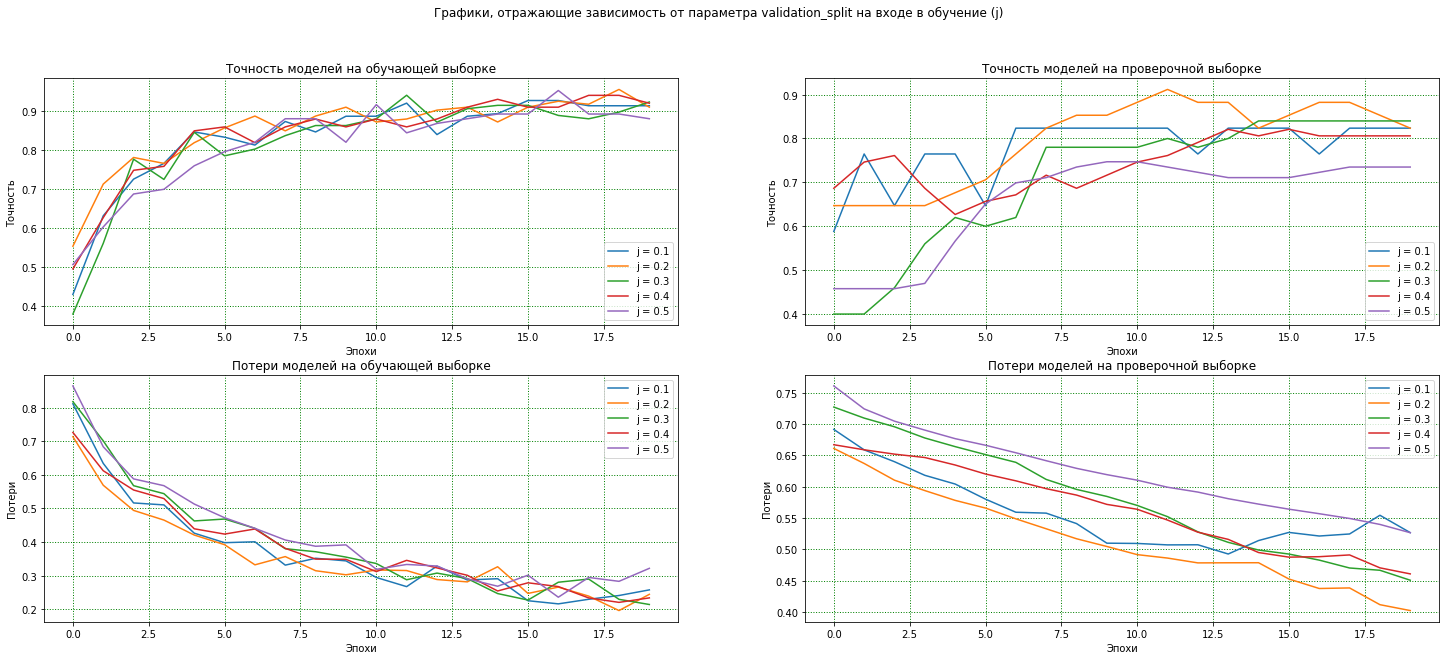

In [0]:
#@title Э2 [validation_split]. Если пытаться анализировать полученные выше данные, то четкой зависимости точности модели от числа и вида добавляемых слоёв мы не наблюдаем. Большой разброс в графиках во всех моделях (хотя можно и выделить некоторые переобучающиеся модели). Теперь ставим другой эксперимент: определим зависимость от параметра validation_split на входе в обучение

testModels2 = []
labels = []
i = 0

for j in [0.1,0.2,0.3,0.4,0.5]:
  M = NN()
  M.createModel()
  M.fitModel(x_train, y_train,v=j)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('j = '+str(j))
  testModels2.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от параметра validation_split на входе в обучение (j)'
runPlot(testModels2,labels,mainLabel)

2/2 [==============================] - 0s 3ms/step - loss: 0.4000 - accuracy: 0.8810


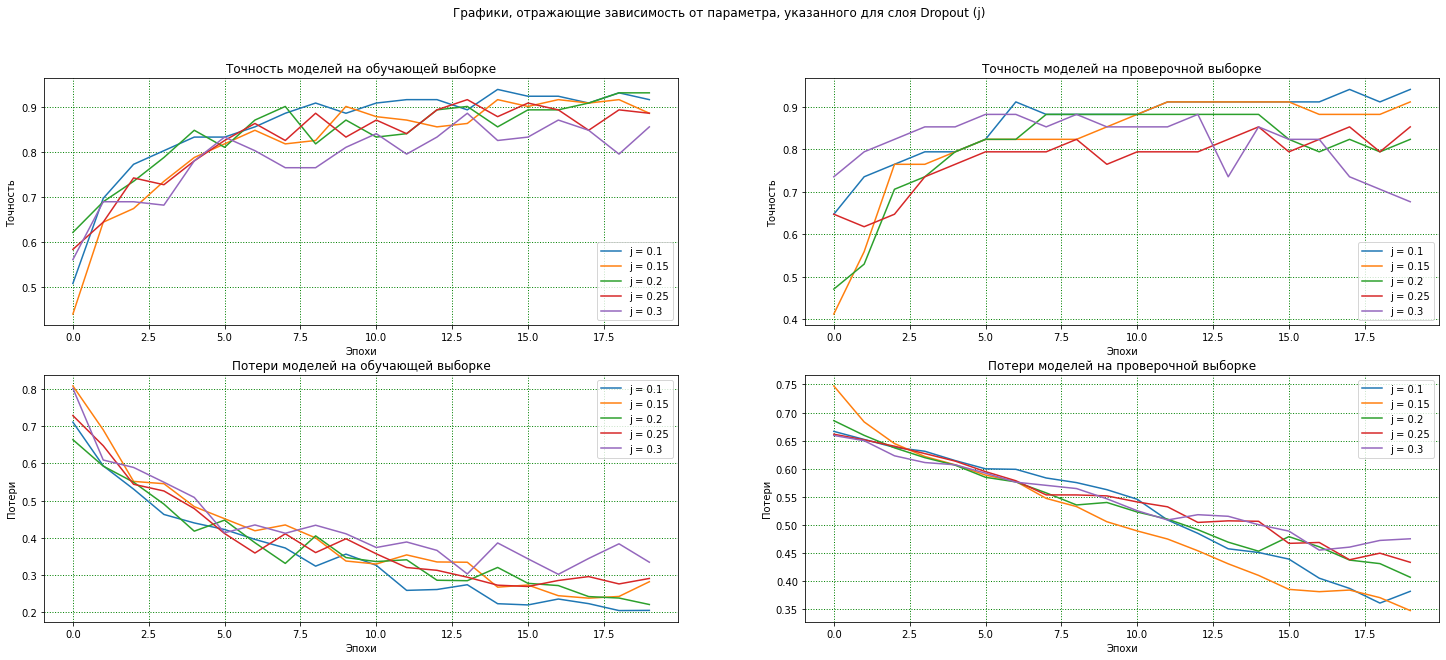

In [0]:
#@title Э3 [Dropout]. Выше мы так же видим, что четкой зависимости точности модели от величины соотношения пакетов обучения/валидации так же не наблюдается, но разброс графиков уже меньше, чем полученных в эксперименте 1. Теперь ставим следующий эксперимент. Попробуем посмотреть, как зависит точность от параметра Dropout.

testModels3 = []
labels = []
i = 0

for j in [0.1,0.15,0.2,0.25,0.3]:
  M = NN()
  M.createModel(koeffDropOut=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('j = '+str(j))
  testModels3.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от параметра, указанного для слоя Dropout (j)'
runPlot(testModels3,labels,mainLabel)

2/2 [==============================] - 0s 4ms/step - loss: 0.3761 - accuracy: 0.8333


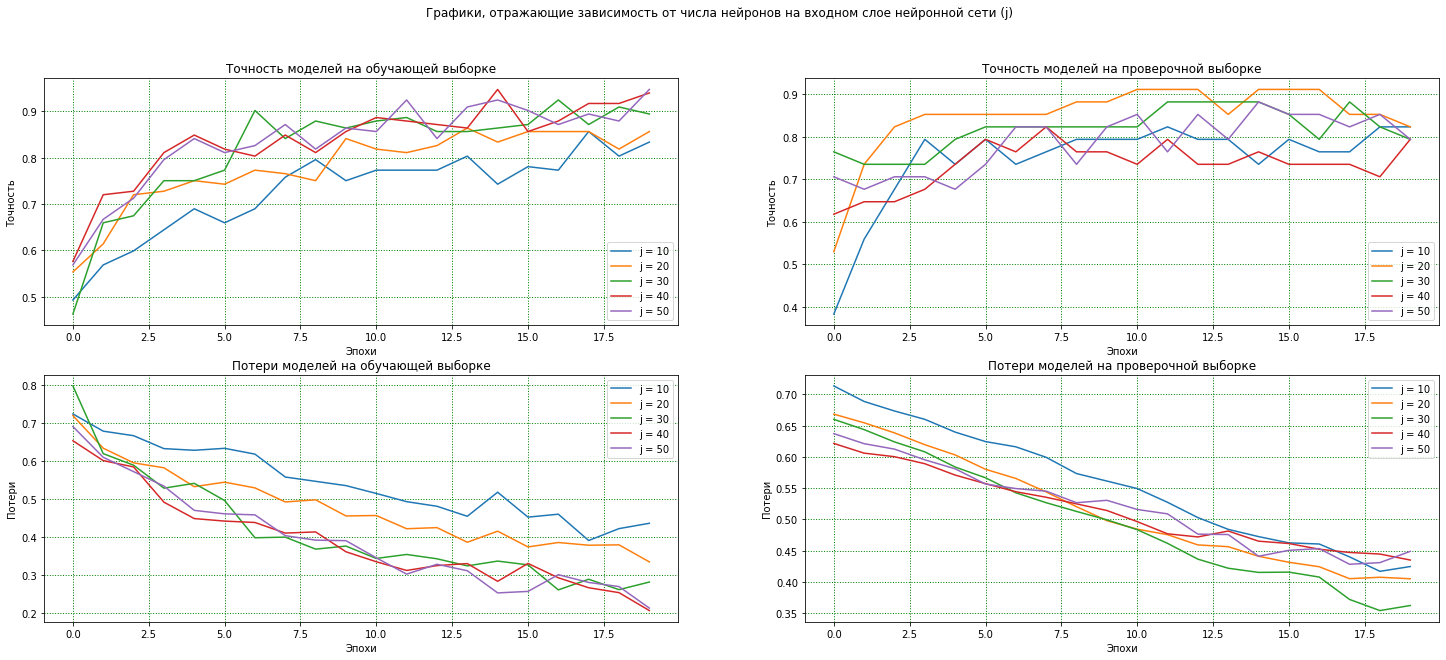

In [0]:
#@title Э4 [neyrons]. Выше мы так же видим, что четкой зависимости точности модели от значения аргумента Dropout так же не наблюдается. Теперь ставим следующий эксперимент. Попробуем посмотреть, как зависит точность от числа нейронов на входном слое.

testModels4 = []
labels = []
i = 0

for j in range(10,60,10):
  M = NN()
  M.createModel(firstLayerNeyrons=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('j = '+str(j))
  testModels4.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от числа нейронов на входном слое нейронной сети (j)'
runPlot(testModels4,labels,mainLabel)

2/2 [==============================] - 0s 4ms/step - loss: 0.4279 - accuracy: 0.8095


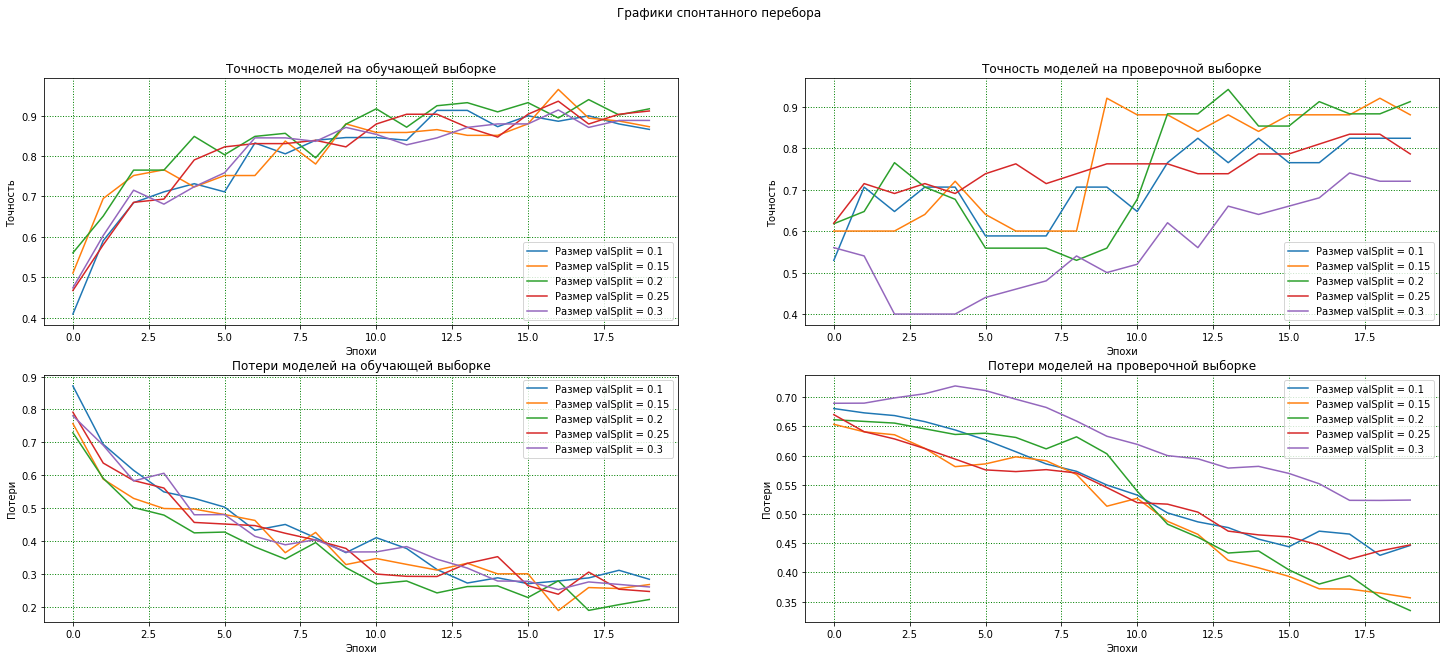

In [0]:
#@title Э5 [various exp's]. Все вышепроведённые эксперименты не показали каких-либо выраженных зависимостей точности модели от исследованных условий. Но кое-что всё-таки можно, хоть и неуверенно, но определить. После 20 эпохи почти во всех наблюдаемых случаях появляется эффект переобучения нейронки. Dropout себя никак в проведённых экспериментах не показал, но введение слоя нормализации BatchNormalization слегка повысило точность модели. В следующем эксперименте просто были опробованы самые разнве варианты конфигурации сети и параметров. Будет оставлена последняя успешная компиляция.

testModels5 = []

i = 0
labels = []
layers = ['BatchNormalization','Dropout','Dense','BatchNormalization','Dense']

for valSplit in [0.1,0.15,0.2,0.25,0.3]:
  M = NN()
  M.createModel(listOfLayers=layers)
  M.fitModel(x_train, y_train,v=valSplit)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('Размер valSplit = '+str(valSplit))
  testModels5.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики спонтанного перебора'
runPlot(testModels5,labels,mainLabel)

## Pro. Вариант 1. Дополнительные эксперименты

In [0]:
#@markdown Для построения следующих моделей будем играть с параметрами обучения. В модель включается оптимизатор Adam с кастомным параметром обучения, получаемым из метода ExponentialDecay, где результирующий коэффициент, принимаемый Adam'ом, рассчитывается по формуле initial_learning_rate * decay_rate ^ (step / decay_steps), в нашем случае: defILR * defDR ^ (step / defDS)

defDR = 0.001        #@param {type:"number"}
defILR = 0.001    #@param {type:"number"}
defDS = 10000       #@param {type:"number"}

#@markdown ---

2/2 [==============================] - 0s 3ms/step - loss: 0.2300 - accuracy: 0.9286

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...



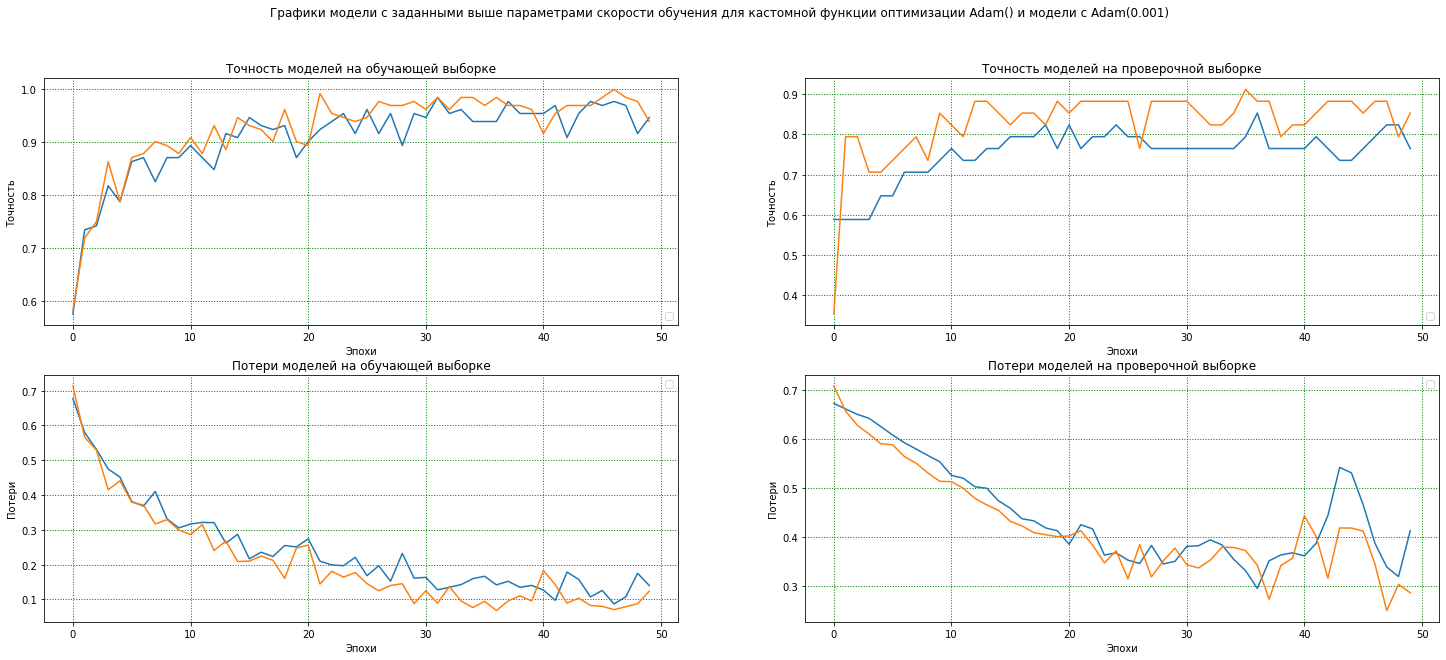

In [0]:
#@title Обучение модели с параметрами по умолчанию (заданными выше) для кастомной функции оптимизации Adam()

m1 = NN()
m1.createModel(optimizer='customAdam',initial_learning_rate=defILR,decay_steps=defDS,decay_rate=defDR)
m1.fitModel(x_train, y_train)
m1.scoreModel(x_test, y_test)
if m1.score[1] >= 0.90:
  print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
  goodModels.append(m1)


m2 = NN()
m2.createModel()
m2.fitModel(x_train, y_train)
m2.scoreModel(x_test, y_test)
if m2.score[1] >= 0.90:
  print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
  goodModels.append(m2)



mainLabel = 'Графики модели с заданными выше параметрами скорости обучения для кастомной функции оптимизации Adam() и модели с Adam(0.001)'
runPlot([m,m2],mainLabel=mainLabel)

2/2 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6667


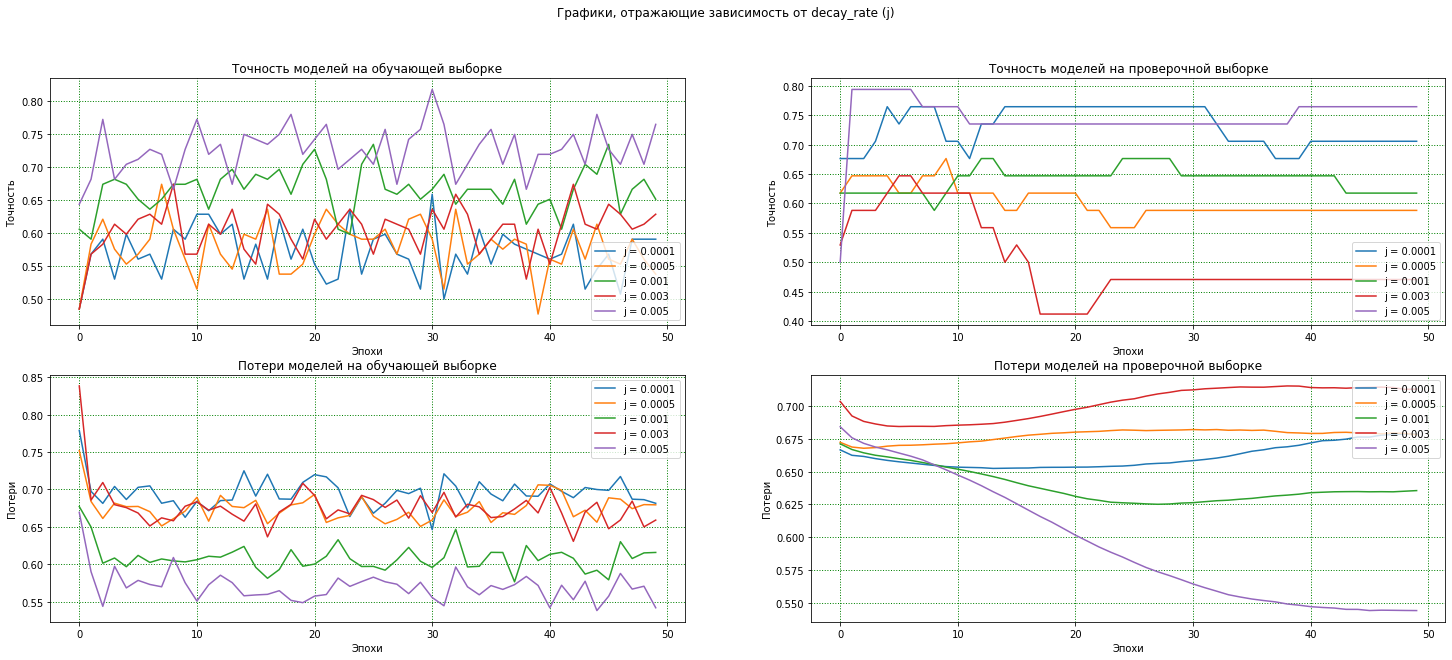

In [0]:
#@title Э6 [decay_rate]. Поиграемся с параметрами шага обучения, decay_rate in Adam+ExponentialDecay

testModels6 = []
i = 0
labels = []

for j in [0.0001,0.0005,0.001,0.003,0.005]:
  M = NN()
  M.createModel(optimizer='customAdam',decay_rate=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('j = '+str(j))
  testModels6.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от decay_rate (j)'
runPlot(testModels6,labels,mainLabel)

2/2 [==============================] - 0s 3ms/step - loss: 0.3485 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 4ms/step - loss: 0.3902 - accuracy: 0.8333


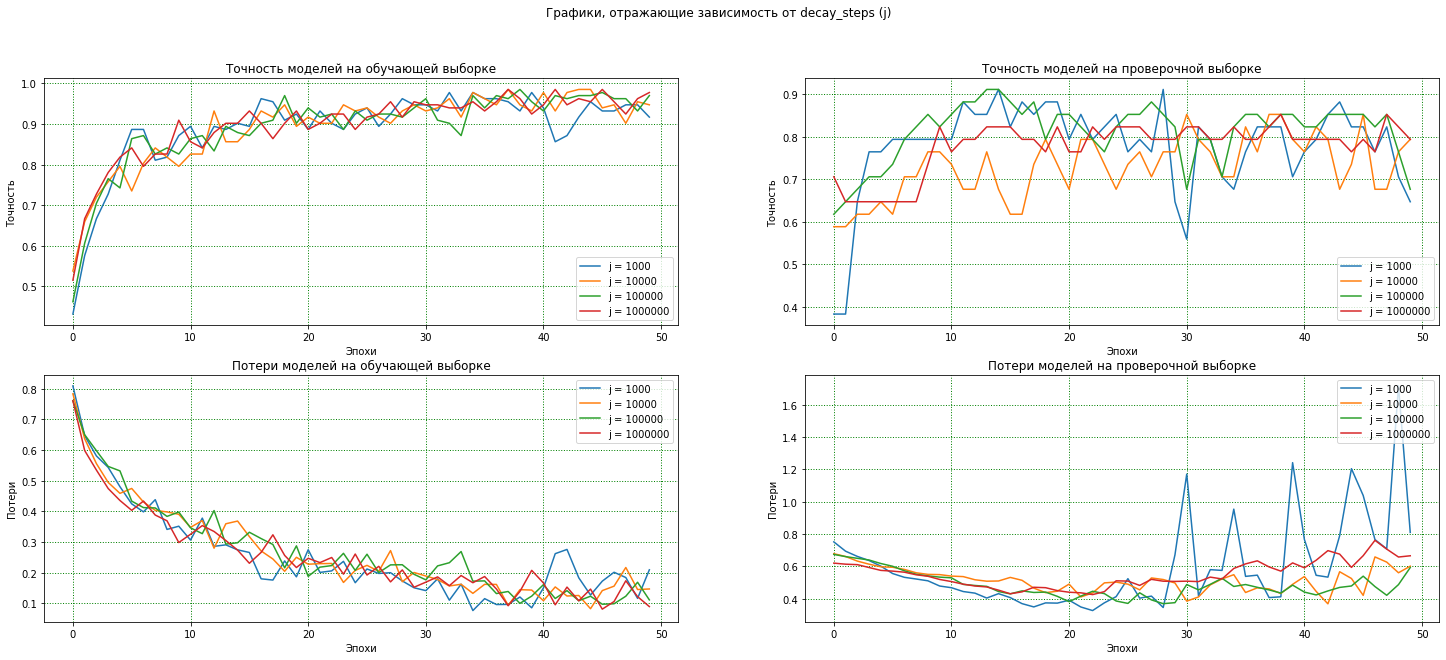

In [0]:
#@title Э7 [decay_steps]. Поиграемся с параметрами шага обучения, decay_steps in Adam+ExponentialDecay

testModels7 = []
i = 0
labels = []

for j in [1000,10000,100000,1000000]:
  M = NN()
  M.createModel(optimizer='customAdam',decay_steps=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('j = '+str(j))
  testModels7.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от decay_steps (j)'
runPlot(testModels7,labels,mainLabel)

2/2 [==============================] - 0s 3ms/step - loss: 673.8224 - accuracy: 0.5000


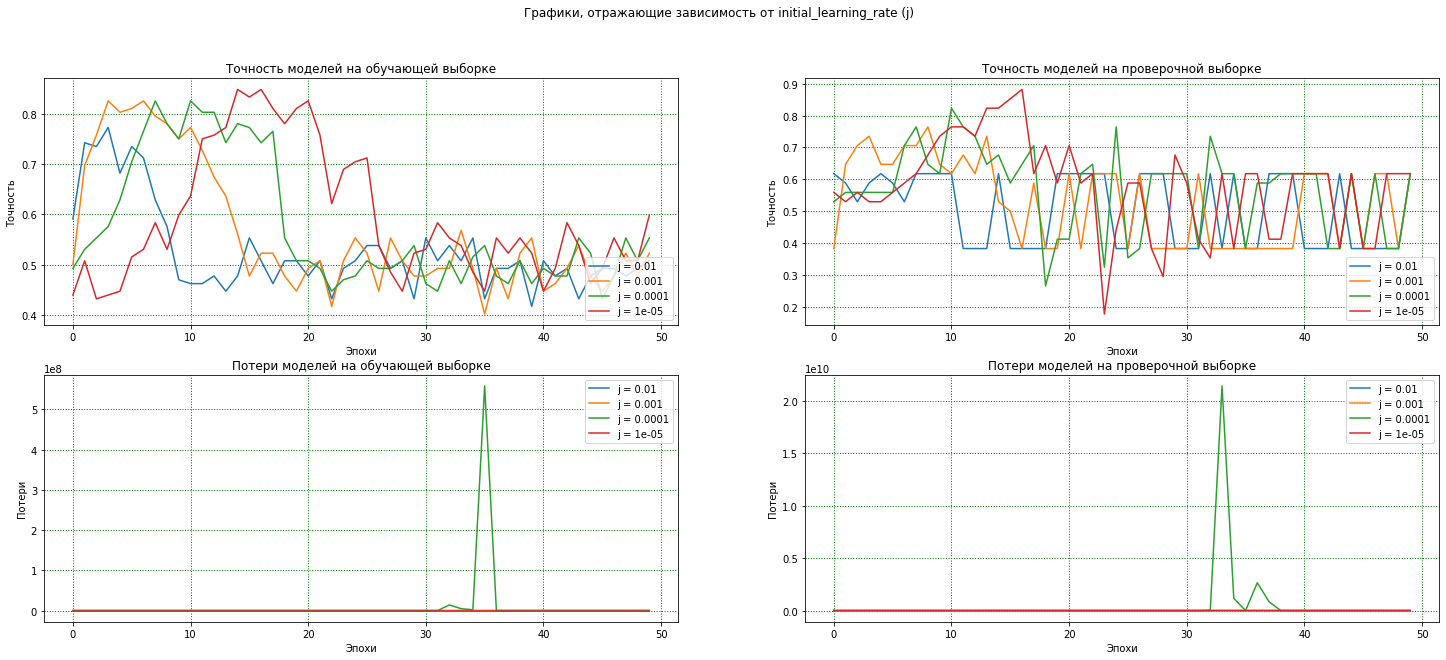

In [0]:
#@title Э8 [initial_learning_rate]. Поиграемся с параметрами шага обучения, initial_learning_rate in Adam+ExponentialDecay

testModels8 = []
i = 0
labels = []

for j in [0.01,0.001,0.0001,0.00001]:
  M = NN()
  M.createModel(optimizer='customAdam',initial_learning_rate=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('j = '+str(j))
  testModels8.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики, отражающие зависимость от initial_learning_rate (j)'
runPlot(testModels8,labels,mainLabel)

# Pro. Вариант 2

По подготовленным на занятии данным создайте обучающую, тестовую и проверочную выборки. По сформированным данным необходимо обучить модель для предсказания цены машины.

Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен. Это можно сделать с помощью следующего метода:

> predict_inverse = y_scaler.inverse_transform(predict).flatten()

где predict - результат предсказания модели).

Затем рассчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.

Рекомендации:
1. В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
2. Метрику для данной задачи можно не использовать.
3. Последний слой модели должен иметь 1 нейрон.

In [0]:
#@title Импорт библиотек и определение глобальных переменных и функций, необходимых для работы с заданием Pro. Вариант 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from google.colab import files

# Инициализируем переменные для последующих экспериментов

class Car:
  """docstring"""
  
  def __init__(self):
    self.history = defaultdict()   
    self.model = Sequential()

  def createModel(self,inputShape0 = 3208):
    '''
      Конструктор. Создается модель с заданными параметрами. Создаются элементы класса
    '''
    self.model.add(Dense(3200, activation='relu', input_shape=(inputShape0, )))
    self.model.add(BatchNormalization())
    self.model.add(Dropout(0.1))
    self.model.add(Dense(1600, activation='relu'))
    self.model.add(BatchNormalization())
    self.model.add(Dropout(0.1))
    self.model.add(Dense(100, activation='relu'))
    self.model.add(BatchNormalization())
    self.model.add(Dense(1, activation='sigmoid'))
    self.model.compile(loss='mse', optimizer='adam')


  def fitModel(self, x, y, batchSize=512, epochs=20):
    self.history = self.model.fit(x,y,batch_size=batchSize,epochs=epochs,validation_split=0.1,verbose=1)
  
  def scoreModel(self, x, y):
    self.score = self.model.evaluate(x, y)

def create_dict(s):
  ret = {}
  for _id, name in enumerate(s):
    ret.update({name: _id})
  return ret

def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [2]:
#@title Загрузка сета машин с юлы
!rm cars_new*
files.upload()
!ls # Выводим содержимое корневой папки

Saving cars_new.csv to cars_new.csv
cars_new.csv  sample_data


In [0]:
#@title Подготовка данных
# Прочитать данные в фрейм
df = pd.read_csv("cars_new.csv",sep=',')
# Создать словари текстовых названий
marks_dict = create_dict(set(df['mark']))
models_dict = create_dict(set(df['model']))
bodies_dict = create_dict(set(df['body']))
kpps_dict = create_dict(set(df['kpp']))
fuels_dict = create_dict(set(df['fuel']))
# Получить массив приведённых цен из столбца цен
prices = np.array(df['price'], dtype=np.float)
# Нормировать большие значения в базе 
years = scale(df['year'])
mileages = scale(df['mileage'])
volumes = scale(df['volume'])
powers = scale(df['power'])
#prices = scale(prices)
# Инициализировать тренировочный массив
x_set = []
y_set = []
# Читать полученные данные из фрейма
for _id, car in enumerate(np.array(df)):
  # Построчно добавлять цены в массив цен
  y_set.append(prices[_id])
  # Построчно создавать тензоры из строк с нормализованными и приведёнными данными
  x_set.append(to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]])
# Преобразовать данные в массив
x_set = np.array(x_set, dtype=np.float)
y_set = np.array(y_set, dtype=np.float)
# 
y_scaler = StandardScaler()
y_set_scaled = y_scaler.fit_transform(y_set.reshape(-1,1)).flatten()
x_train, x_test, y_train, y_test = train_test_split(x_set,y_set_scaled,test_size=0.2)

In [5]:
#@title Проверим, сколько на входе нужно иметь нейронов

x_train.shape

(56095, 3208)

In [4]:
#@title Создание модели, компиляция, обучение, получение предсказания, вывод итогов.

model_ula = Car()
model_ula.createModel(x_train.shape[1])
model_ula.fitModel(x=x_train,y=y_train)
predict = model_ula.model.predict(x_test)
predict_inverse = y_scaler.inverse_transform(predict).flatten()

dfCars = pd.DataFrame()
dfCars['y_test'] = pd.Series(y_scaler.inverse_transform(y_test).flatten())
dfCars['predict_inverse'] = pd.Series(predict_inverse)
dfCars['error'] = pd.Series(np.abs(dfCars['predict_inverse'] - dfCars['y_test']))
dfCars['percent_error'] = pd.Series(dfCars['error'] / dfCars['y_test'] * 100)
dfCars.head(10)
print('Средняя ошибка предсказания цены: ',np.mean(dfCars['error']),
      '\nСредний процент ошибки предсказаний: ',np.mean(dfCars['percent_error']),
      '\nСуммарный процент ошибки предсказаний: ',np.sum(dfCars['percent_error']))

Epoch 1/20
99/99 [==============================] - 74s 749ms/step - loss: 0.7316 - val_loss: 0.8062
Epoch 2/20
99/99 [==============================] - 74s 748ms/step - loss: 0.6931 - val_loss: 0.7639
Epoch 3/20
99/99 [==============================] - 75s 754ms/step - loss: 0.6899 - val_loss: 0.6616
Epoch 4/20
99/99 [==============================] - 76s 768ms/step - loss: 0.6890 - val_loss: 0.5528
Epoch 5/20
99/99 [==============================] - 74s 749ms/step - loss: 0.6887 - val_loss: 0.5253
Epoch 6/20
99/99 [==============================] - 74s 748ms/step - loss: 0.6883 - val_loss: 0.5212
Epoch 7/20
99/99 [==============================] - 74s 752ms/step - loss: 0.6875 - val_loss: 0.5189
Epoch 8/20
99/99 [==============================] - 74s 748ms/step - loss: 0.6869 - val_loss: 0.5189
Epoch 9/20
99/99 [==============================] - 74s 750ms/step - loss: 0.6871 - val_loss: 0.5182
Epoch 10/20
99/99 [==============================] - 75s 754ms/step - loss: 0.6868 - val_lo

## Pro. Вариант 2. Дополнительные эксперименты

In [6]:
#@title Как видим, обучение показывает не очень хороший результат. Можно попробовать его улучшить. Для этого проанализируем данные.

df.head(20)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0
5,hyundai,creta 1 поколение,985000,2016,34067,кроссовер,автомат,бензин,2.0,150.0
6,kia,ceed 2 поколение,589000,2013,98000,хетчбэк,автомат,бензин,1.6,129.0
7,toyota,corolla e140,500000,2008,141000,седан,автомат,бензин,1.6,124.0
8,mercedes-benz,c-класс 180 w204/s204/c204 [рестайлинг],1320000,2015,81112,седан,автомат,бензин,1.6,156.0
9,bmw,7 серия 735 e65/e66,270000,2001,300000,седан,автомат,бензин,3.6,272.0


In [7]:
#@title В поле model видим микс из слов, и можно посмотреть, насколько большой микс здесь зарыт.

print('В столбце model',len(set(df['model'].unique())),'уникальных значений, состоящих из нескольких слов')

В столбце model 3156 уникальных значений, состоящих из нескольких слов


In [3]:
#@title Так же можно обнаружить, что чаще всего запись в столбце model начинается с названия модели, а дальше идут детали, модификации. Можно отделить детали и модификации от остального. Добавим три столбца в фрейм: рестайлинг, поколение, серия, класс. 


#@markdown Примечание: если дополнительный эксперимент крашится, не хватает памяти в виртуальном опружении, то можно перезапустить Runtime, загрузить библиотеки и функции в первой секции, затем выполнить загрузку сета машин с юлы, а затем сразу запустить эту ячейку. При крахе указать параметр "FailOnRun" = "yes" ниже:

FailOnRun = "yes"  #@param ['yes', 'no']

if FailOnRun == "yes":
  # Прочитать данные в фрейм
  df = pd.read_csv("cars_new.csv",sep=',')

df['generation'] = df['model'].str.extract(r'(\S+.поколение)')
df['restyle'] = df['model'].str.extract(r'(\S+\sрестайлинг\S+|\Sрестайлинг\S+)')
df['series'] = df['model'].str.extract(r'(\S+.серия)')
df['class'] = df['model'].str.extract(r'(\S+.класс)')
df['model_leftover'] = df['model'].str.replace(r'(\S+.серия)|(\S+\sрестайлинг\S+|\Sрестайлинг\S+)|(\S+.поколение)|(\S+.класс)','')

df.head(10)


,mark,model,price,year,mileage,body,kpp,fuel,volume,power,generation,restyle,series,class,model_leftover
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0,NaN,NaN,NaN,NaN,cerato
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0,1 поколение,[2-й рестайлинг],NaN,NaN,nexia
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0,3 поколение,[рестайлинг],NaN,NaN,jimny
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0,NaN,[рестайлинг],NaN,NaN,x1 18 e84
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0,1 поколение,NaN,NaN,NaN,lacetti
5,hyundai,creta 1 поколение,985000,2016,34067,кроссовер,автомат,бензин,2.0,150.0,1 поколение,NaN,NaN,NaN,creta
6,kia,ceed 2 поколение,589000,2013,98000,хетчбэк,автомат,бензин,1.6,129.0,2 поколение,NaN,NaN,NaN,ceed
7,toyota,corolla e140,500000,2008,141000,седан,автомат,бензин,1.6,124.0,NaN,NaN,NaN,NaN,corolla e140
8,mercedes-benz,c-класс 180 w204/s204/c204 [рестайлинг],1320000,2015,81112,седан,автомат,бензин,1.6,156.0,NaN,[рестайлинг],NaN,c-класс,180 w204/s204/c204
9,bmw,7 серия 735 e65/e66,270000,2001,300000,седан,автомат,бензин,3.6,272.0,NaN,NaN,7 серия,NaN,735 e65/e66


In [9]:
#@title Приглядимся повнимательнее к данным в столбце model_leftover. Выглядит так, что в нем осталось название модели. Посмотрим количество записей

print('В столбце model_leftover',len(set(df['model_leftover'].unique())),'уникальных значений, состоящих из нескольких слов')

В столбце model_leftover 2691 уникальных значений, состоящих из нескольких слов


In [9]:
#@title Всё ещё много. Посмотрим, что можно ещё выделить. Можно посмотреть часто встречающиеся слова в новом столбце "model_leftover", где находится остаток от "откусывания", произведенного выше.

dfCols = df['model_leftover'].str.split(expand=True)
dfCols.fillna(value=0, inplace=True)
newset = dfCols.values.flatten()
c = Counter()
for word in newset:
  c[word] += 1
for tupl in c.most_common(30):
  p = isinstance(tupl[0], int)
  if not p:
    if len(tupl[0])>3:
      print('Сочетание',tupl[0],'встречается',tupl[1],'раз')

Сочетание focus встречается 2386 раз
Сочетание astra встречается 1932 раз
Сочетание nexia встречается 1754 раз
Сочетание octavia встречается 1440 раз
Сочетание lancer встречается 1218 раз
Сочетание solaris встречается 1176 раз
Сочетание logan встречается 1161 раз
Сочетание matiz встречается 1146 раз
Сочетание passat встречается 1138 раз
Сочетание m150 встречается 1070 раз
Сочетание niva встречается 1004 раз
Сочетание family/h встречается 867 раз
Сочетание polo встречается 758 раз
Сочетание pajero встречается 723 раз
Сочетание cruze встречается 694 раз
Сочетание grand встречается 679 раз
Сочетание j300 встречается 668 раз
Сочетание sportage встречается 642 раз
Сочетание lacetti встречается 627 раз
Сочетание corolla встречается 619 раз
Сочетание duster встречается 604 раз


In [4]:
#@title Можно ещё придумать способ улучшить сет, но пока остановимся на этом. Переформулируем наш сет данных.

dfnew = df[['mark','price','year','mileage','body','kpp','fuel','volume','power','generation','restyle','series','class','model_leftover']]
dfnew = dfnew.fillna(0)
dfnew

,mark,price,year,mileage,body,kpp,fuel,volume,power,generation,restyle,series,class,model_leftover
0,kia,996000,2018,28000,седан,автомат,бензин,2.0,150.0,0,0,0,0,cerato
1,daewoo,140200,2012,60500,седан,механика,бензин,1.5,80.0,1 поколение,[2-й рестайлинг],0,0,nexia
2,suzuki,750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0,3 поколение,[рестайлинг],0,0,jimny
3,bmw,970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0,0,[рестайлинг],0,0,x1 18 e84
4,chevrolet,205000,2007,151445,седан,механика,бензин,1.4,95.0,1 поколение,0,0,0,lacetti
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70114,skoda,310000,2011,165000,хетчбэк,механика,бензин,1.2,70.0,0,[рестайлинг],0,0,fabia 5j
70115,ford,400000,2011,125000,хетчбэк,механика,бензин,1.6,105.0,3 поколение,0,0,0,focus
70116,mazda,1140000,2013,89981,кроссовер,автомат,бензин,2.0,150.0,1 поколение,0,0,0,cx-5
70117,toyota,550550,2006,183000,минивэн,автомат,бензин,1.3,92.0,2 поколение,0,0,0,bb


In [0]:
#@title Подготовка данных. Пробуем обновленный фрейм данных.
# Создать словари текстовых названий
marks_dict = create_dict(set(dfnew['mark']))            #0
model_leftover_dict = create_dict(set(dfnew['model_leftover'])) #13
class_dict = create_dict(set(dfnew['class']))           #12
series_dict = create_dict(set(dfnew['series']))         #11
restyle_dict = create_dict(set(dfnew['restyle']))       #10
gen_dict = create_dict(set(dfnew['generation']))        #9
bodies_dict = create_dict(set(dfnew['body']))           #4
kpps_dict = create_dict(set(dfnew['kpp']))              #5
fuels_dict = create_dict(set(dfnew['fuel']))            #6
# Получить массив приведённых цен из столбца цен        
prices = np.array(dfnew['price'], dtype=np.float)       #1
# Нормировать большие значения в базе 
years = scale(dfnew['year'])                            #3
mileages = scale(dfnew['mileage'])                      #4
volumes = scale(dfnew['volume'])                        #7
powers = scale(dfnew['power'])                          #8
#prices = scale(prices)
# Инициализировать тренировочный массив
x_set2 = []
y_set2 = []
# Читать полученные данные из фрейма
for _id, car in enumerate(np.array(dfnew)):
  # Построчно добавлять цены в массив цен
  y_set2.append(prices[_id])
  # Построчно создавать тензоры из строк с нормализованными и приведёнными данными
  x_set2.append(to_ohe(car[0], marks_dict) + to_ohe(car[13], model_leftover_dict) + 
               to_ohe(car[12], class_dict) + to_ohe(car[11], series_dict) + to_ohe(car[10], restyle_dict) + to_ohe(car[9], gen_dict) + 
               to_ohe(car[4], bodies_dict) + to_ohe(car[5], kpps_dict) + to_ohe(car[6], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]])
# Преобразовать данные в массив
x_set2 = np.array(x_set2, dtype=np.float)
y_set2 = np.array(y_set2, dtype=np.float)
# 
y_scaler2 = StandardScaler()
y_set_scaled2 = y_scaler2.fit_transform(y_set2.reshape(-1,1)).flatten()
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_set2,y_set_scaled2,test_size=0.2)

In [6]:
#@title Проверим, сколько на входе нужно иметь нейронов

x_train2.shape

(56095, 2793)

In [8]:
#@title Повторное создание модели, компиляция, обучение, получение предсказания, вывод итогов.

model_ula2 = Car()
model_ula2.createModel(inputShape0=x_train2.shape[1])
model_ula2.fitModel(x=x_train2,y=y_train2)
predict2 = model_ula2.model.predict(x_test2)
predict_inverse2 = y_scaler2.inverse_transform(predict2).flatten()

dfCars2 = pd.DataFrame()
dfCars2['y_test'] = pd.Series(y_scaler2.inverse_transform(y_test2).flatten())
dfCars2['predict_inverse'] = pd.Series(predict_inverse2)
dfCars2['error'] = pd.Series(np.abs(dfCars2['predict_inverse'] - dfCars2['y_test']))
dfCars2['percent_error'] = pd.Series(dfCars2['error'] / dfCars2['y_test'] * 100)
dfCars2.head(10)
print('Средняя ошибка предсказания цены: ',np.mean(dfCars2['error']),
      '\nСредний процент ошибки предсказаний: ',np.mean(dfCars2['percent_error']),
      '\nСуммарный процент ошибки предсказаний: ',np.sum(dfCars2['percent_error']))

Epoch 1/20
99/99 [==============================] - 70s 704ms/step - loss: 0.6701 - val_loss: 1.0444
Epoch 2/20
99/99 [==============================] - 69s 701ms/step - loss: 0.6332 - val_loss: 1.0097
Epoch 3/20
99/99 [==============================] - 69s 701ms/step - loss: 0.6307 - val_loss: 0.9000
Epoch 4/20
99/99 [==============================] - 70s 703ms/step - loss: 0.6290 - val_loss: 0.7660
Epoch 5/20
99/99 [==============================] - 69s 702ms/step - loss: 0.6279 - val_loss: 0.7374
Epoch 6/20
99/99 [==============================] - 73s 735ms/step - loss: 0.6255 - val_loss: 0.7259
Epoch 7/20
99/99 [==============================] - 69s 699ms/step - loss: 0.6209 - val_loss: 0.7268
Epoch 8/20
99/99 [==============================] - 69s 701ms/step - loss: 0.6207 - val_loss: 0.7250
Epoch 9/20
99/99 [==============================] - 69s 702ms/step - loss: 0.6205 - val_loss: 0.7239
Epoch 10/20
99/99 [==============================] - 69s 701ms/step - loss: 0.6199 - val_lo

In [0]:
#@title Увы, наши изменения практически не повлияли на качество предсказания моделью...

## Благодарю за внимание!